![Cabec%CC%A7alho_notebook.png](cabecalho_notebook.png)

# Classificação de Atividade Humana com PCA

Vamos trabalhar com a base da demonstração feita em aula, mas vamos explorar um pouco melhor como é o desempenho da árvore variando o número de componentes principais.

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# Definindo os nomes dos arquivos
filename_features = "features.txt"
filename_labels = "activity_labels.txt"
filename_subtrain = "subject_train.txt"
filename_xtrain = "X_train.txt"
filename_ytrain = "y_train.txt"
filename_subtest = "subject_test.txt"
filename_xtest = "X_test.txt"
filename_ytest = "y_test.txt"

# Lendo os arquivos
features = pd.read_csv(filename_features, header=None, names=['nome_var'], sep="#")
labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])

# Extraindo os nomes das variáveis como uma lista
feature_names = features['nome_var'].tolist()

# Lendo os dados de treino e teste
subject_train = pd.read_csv(filename_subtrain, header=None, names=['subject_id'])
X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=feature_names)
y_train = pd.read_csv(filename_ytrain, header=None, names=['cod_label'])

subject_test = pd.read_csv(filename_subtest, header=None, names=['subject_id'])
X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=feature_names)
y_test = pd.read_csv(filename_ytest, header=None, names=['cod_label'])

C:\Users\milla\AppData\Local\Temp\ipykernel_12232\1719400722.py:24: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv(filename_labels, delim_whitespace=True, header=None, names=['cod_label', 'label'])
C:\Users\milla\AppData\Local\Temp\ipykernel_12232\1719400722.py:31: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv(filename_xtrain, delim_whitespace=True, header=None, names=feature_names)
C:\Users\milla\AppData\Local\Temp\ipykernel_12232\1719400722.py:35: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv(filename_xtest, delim_whitespace=True, header=None, names=feature_names)


## PCA com variáveis padronizadas

Reflexão sobre a escala das variáveis:

**Variáveis em métricas muito diferentes** podem interferir na análise de componentes principais. Lembra que variância é informação pra nós? Pois bem, tipicamente se há uma variável monetária como salário, vai ter uma ordem de variabilidade bem maior que número de filhos, tempo de emprego ou qualquer variável dummy. Assim, as variáveis de maior variância tendem a "dominar" a análise. Nesses casos é comum usar a padronização das variáveis.

Faça duas análises de componentes principais para a base do HAR - com e sem padronização e compare:

- A variância explicada por componente
- A variância explicada acumulada por componente
- A variância percentual por componente
- A variância percentual acumulada por componente
- Quantas componentes você escolheria, em cada caso para explicar 90% da variância?

In [39]:
%%time

def padroniza(s):
    if s.std() > 0:
        s = (s - s.mean())/s.std()
    return s

X_train_pad = pd.DataFrame(X_train).apply(padroniza, axis=0)
X_test_pad  = pd.DataFrame(X_test).apply(padroniza, axis=0)
X_train_pad.head()

CPU times: total: 109 ms
Wall time: 369 ms


,1 tBodyAcc-mean()-X,2 tBodyAcc-mean()-Y,3 tBodyAcc-mean()-Z,4 tBodyAcc-std()-X,5 tBodyAcc-std()-Y,6 tBodyAcc-std()-Z,7 tBodyAcc-mad()-X,8 tBodyAcc-mad()-Y,9 tBodyAcc-mad()-Z,10 tBodyAcc-max()-X,...,552 fBodyBodyGyroJerkMag-meanFreq(),553 fBodyBodyGyroJerkMag-skewness(),554 fBodyBodyGyroJerkMag-kurtosis(),"555 angle(tBodyAccMean,gravity)","556 angle(tBodyAccJerkMean),gravityMean)","557 angle(tBodyGyroMean,gravityMean)","558 angle(tBodyGyroJerkMean,gravityMean)","559 angle(X,gravityMean)","560 angle(Y,gravityMean)","561 angle(Z,gravityMean)"
0,0.200628,-0.063678,-0.419600,-0.868755,-0.939377,-0.737479,-0.859758,-0.938955,-0.766385,-0.855978,...,-0.795305,0.025958,-0.276380,-0.360579,0.062935,-0.778374,-0.026079,-0.687172,0.407918,-0.007567
1,0.055944,0.031484,-0.253891,-0.875366,-0.923839,-0.849247,-0.868472,-0.921936,-0.848870,-0.871300,...,0.130605,-0.897296,-0.767938,0.133002,-0.021460,-1.218722,1.484369,-0.694091,0.409089,0.007875
2,0.073510,-0.043414,-0.076289,-0.868980,-0.907698,-0.893724,-0.863078,-0.898793,-0.896640,-0.863264,...,1.152257,-0.260860,-0.438286,-0.377815,0.391949,0.151197,1.704085,-0.702191,0.410260,0.026501
3,0.066691,-0.208407,-0.249695,-0.870566,-0.939959,-0.921743,-0.864445,-0.938060,-0.925216,-0.863264,...,1.112694,0.591005,0.463123,-0.135016,-0.033635,1.037781,-1.002951,-0.701636,0.414622,0.031712
4,0.030467,0.027585,-0.109840,-0.875128,-0.934815,-0.921281,-0.867325,-0.931726,-0.927965,-0.870201,...,-0.149567,-0.138505,-0.240296,0.340383,0.268468,1.125841,-1.276196,-0.700104,0.425434,0.045222


In [40]:
%%time
pca_X_train = PCA().fit(X_train)
pca_X_train_pad = PCA().fit(X_train_pad)

CPU times: total: 4.25 s
Wall time: 1.04 s


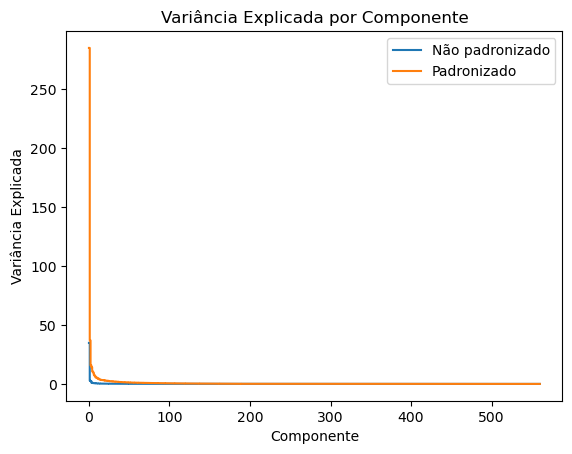

In [41]:
fig, ax = plt.subplots()
ax.set_xlabel("Componente")
ax.set_ylabel("Variância Explicada")
ax.set_title("Variância Explicada por Componente")
ax.plot(pca_X_train.explained_variance_, label="Não padronizado", drawstyle="steps-post")
ax.plot(pca_X_train_pad.explained_variance_, label="Padronizado", drawstyle="steps-post")

ax.legend()
plt.show()

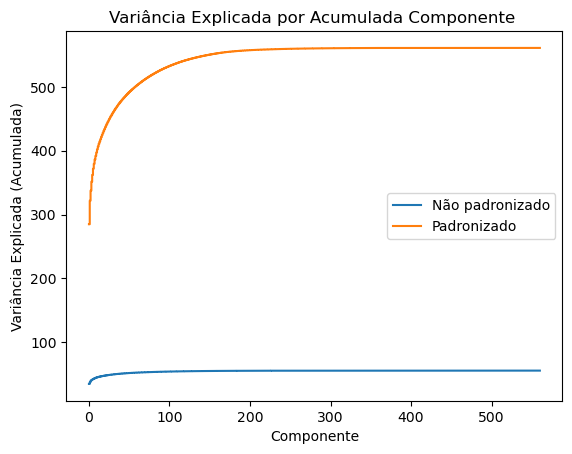

In [42]:
fig, ax = plt.subplots()
ax.set_xlabel("Componente")
ax.set_ylabel("Variância Explicada (Acumulada)")
ax.set_title("Variância Explicada por Acumulada Componente ")
ax.plot(pca_X_train.explained_variance_.cumsum(), label="Não padronizado", drawstyle="steps-post")
ax.plot(pca_X_train_pad.explained_variance_.cumsum(), label="Padronizado", drawstyle="steps-post")

ax.legend()
plt.show()

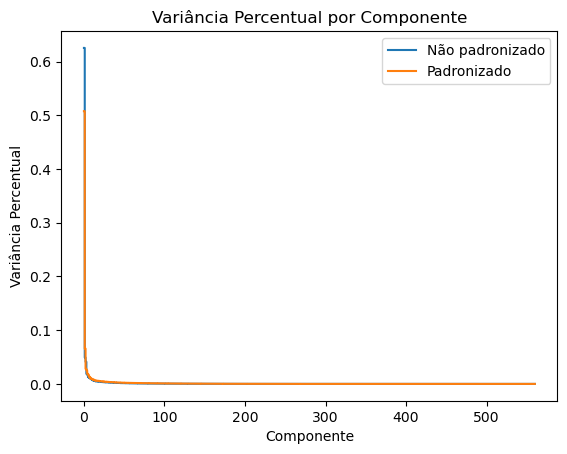

In [43]:
fig, ax = plt.subplots()
ax.set_xlabel("Componente")
ax.set_ylabel("Variância Percentual")
ax.set_title("Variância Percentual por Componente")
ax.plot(pca_X_train.explained_variance_ratio_, label="Não padronizado",    drawstyle="steps-post")
ax.plot(pca_X_train_pad.explained_variance_ratio_, label="Padronizado", drawstyle="steps-post")

ax.legend()
plt.show()

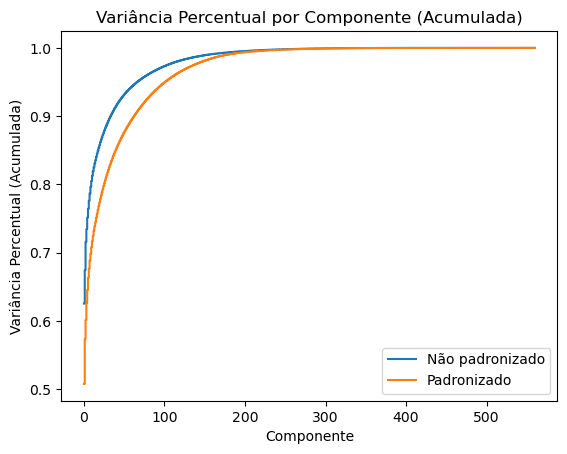

In [44]:
fig, ax = plt.subplots()
ax.set_xlabel("Componente")
ax.set_ylabel("Variância Percentual (Acumulada)")
ax.set_title("Variância Percentual por Componente (Acumulada)")
ax.plot(pca_X_train.explained_variance_ratio_.cumsum(), label="Não padronizado",    drawstyle="steps-post")
ax.plot(pca_X_train_pad.explained_variance_ratio_.cumsum(), label="Padronizado", drawstyle="steps-post")

ax.legend()
plt.show()

In [45]:
%%time

pca = PCA()

princomp = pca.fit(X_train)

componentes = princomp.transform(X_train)

n_componentes = X_train.shape[1]

nomes_pca = ['CP' + str(x+1) for x in list(range(n_componentes))]

pd.DataFrame(data=componentes, columns=nomes_pca)

CPU times: total: 1.38 s
Wall time: 296 ms


,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-5.520280,-0.290278,-1.529929,1.333242,1.425089,-0.194708,0.577454,0.691490,-1.222865,-0.363414,...,-4.837716e-17,-1.025490e-16,-4.000642e-17,1.718116e-17,-5.939578e-17,3.676713e-15,-2.938799e-16,-4.362003e-17,-4.262491e-17,-1.227134e-17
1,-5.535350,-0.082530,-1.924804,0.671273,0.671260,0.735144,-0.616908,-0.771714,-0.615496,-0.895525,...,-6.768372e-17,3.548977e-17,-7.268525e-17,-8.871886e-18,-1.129698e-16,7.053588e-16,-1.921308e-16,-2.788375e-16,-7.518511e-17,-7.812686e-17
2,-5.474988,0.287387,-2.144642,0.531806,0.207824,-0.037772,0.057628,0.093917,-0.063147,-0.216898,...,-1.522579e-17,4.369524e-17,-9.594664e-17,-2.396339e-17,-7.720398e-17,-6.500666e-17,7.957927e-18,-2.110504e-17,-2.662101e-16,-1.192331e-16
3,-5.677232,0.897031,-2.018220,0.157125,0.759085,1.079547,-0.267805,-0.731391,0.281296,0.466269,...,-2.737544e-17,1.469303e-16,-5.724820e-17,-3.045594e-17,-8.261923e-17,7.175090e-16,5.200313e-17,-6.409596e-19,-4.918729e-17,3.995209e-17
4,-5.748749,1.162952,-2.139533,0.207823,0.473090,0.463035,-0.152227,-0.107509,0.289819,0.539206,...,-3.880599e-17,-2.231718e-17,-9.449943e-17,8.349784e-18,-3.204428e-17,-4.598473e-16,-8.312540e-17,-8.208608e-17,-1.440004e-16,-3.980076e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,6.253517,-2.636767,0.448229,1.476516,-0.767298,-0.268023,-1.348600,-0.463529,1.463389,0.210285,...,-4.168122e-17,5.021486e-17,4.756348e-17,-1.131012e-16,3.056162e-17,-1.588618e-15,1.490916e-17,-2.398592e-16,-6.532518e-17,-3.939241e-17
7348,5.782321,-2.437814,0.462731,1.711345,-0.825446,-0.403852,-1.257430,-0.319120,0.424317,-0.814650,...,-7.527059e-17,1.721439e-17,1.271027e-16,-3.677676e-17,3.607985e-17,2.478006e-16,1.117245e-16,-3.995512e-16,-1.239087e-16,-1.074921e-16
7349,5.857505,-3.081843,0.671207,2.253646,-0.494577,0.391518,-1.000016,-0.162912,0.291533,1.248849,...,-1.206074e-16,-8.230226e-17,9.987732e-17,-1.850287e-17,4.054310e-17,-9.869135e-16,-8.616532e-17,6.529412e-17,-2.034741e-16,-3.104421e-16
7350,5.421095,-3.426430,0.671243,2.013981,-0.612601,0.443119,-1.445597,-0.112817,0.813037,1.681171,...,-9.728608e-17,1.777113e-17,1.218384e-16,1.150128e-17,1.538307e-17,-1.179316e-16,-5.590266e-17,-1.201285e-16,6.152820e-17,-1.914390e-16


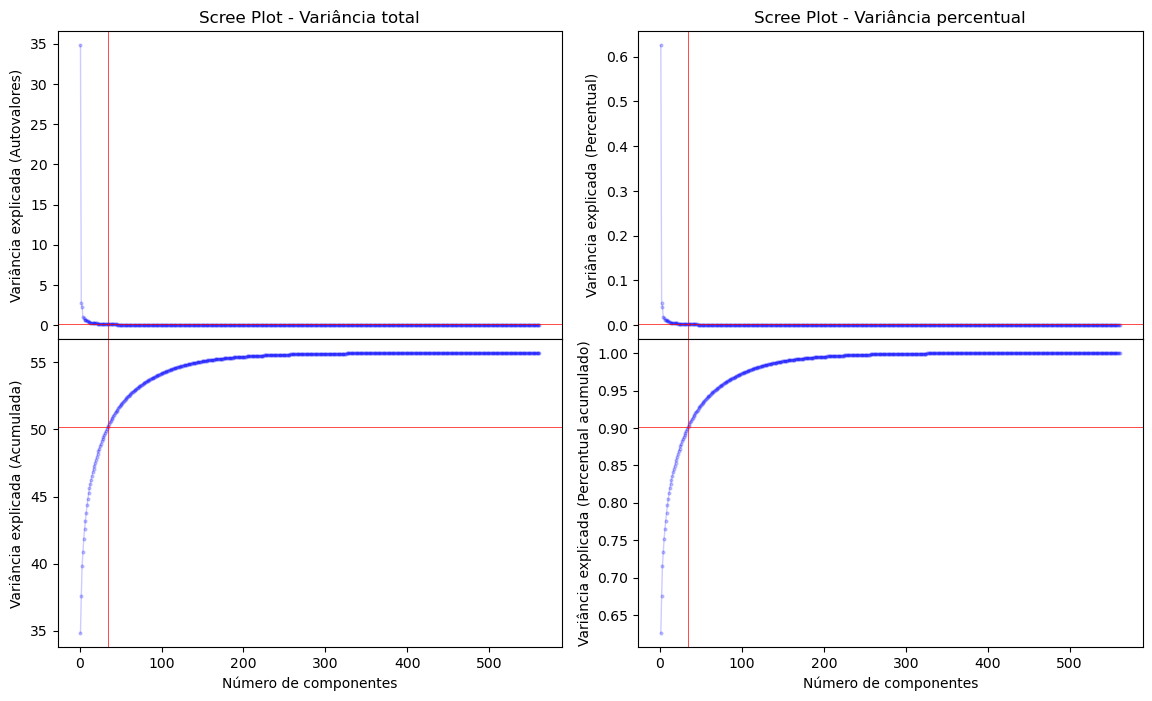

Para explicar 90% da variância sem a padronização das variáveis, são necessárias 34 componentes.


In [46]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

varexplicada = .90  # Define a variância explicada desejada
ncomp_criterio = (princomp.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1

num_componentes = np.arange(princomp.n_components_) + 1
ax[0, 0].plot(num_componentes, princomp.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0 ,0].set_title('Scree Plot - Variância total')
ax[0, 0].set_xlabel('Número de componentes')
ax[0, 0].set_ylabel('Variância explicada (Autovalores)')

ax[1, 0].plot(num_componentes, princomp.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 0].set_xlabel('Número de componentes')
ax[1, 0].set_ylabel('Variância explicada (Acumulada)')

ax[0, 1].plot(num_componentes, princomp.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0, 1].set_title('Scree Plot - Variância percentual')
ax[0, 1].set_xlabel('Número de componentes')
ax[0, 1].set_ylabel('Variância explicada (Percentual)')

ax[1, 1].plot(num_componentes, princomp.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 1].set_xlabel('Número de componentes')
ax[1, 1].set_ylabel('Variância explicada (Percentual acumulado)')

ax[0, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[1, 0].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)
ax[0, 1].axvline(x=ncomp_criterio, color='r', linestyle='-', linewidth=.5)

ax[0, 0].axhline(y=princomp.explained_variance_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 0].axhline(y=princomp.explained_variance_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[0, 1].axhline(y=princomp.explained_variance_ratio_[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)
ax[1, 1].axhline(y=princomp.explained_variance_ratio_.cumsum()[ncomp_criterio-1], color='r', linestyle='-', linewidth=.5)

plt.show()

print(f'Para explicar 90% da variância sem a padronização das variáveis, são necessárias {ncomp_criterio} componentes.')

In [47]:
%%time

pc_treino_pad = pca_X_train_pad.transform(X_train)
pc_teste_pad = pca_X_train_pad.transform(X_test)

n = 10

colunas = ['cp'+str(x+1) for x in list(range(n))]

pc_train_pad = pd.DataFrame(pc_treino_pad[:, :n], columns=colunas)
pc_test_pad = pd.DataFrame(pc_teste_pad[:, :n], columns=colunas)

clf_pad = DecisionTreeClassifier(random_state=1234, ccp_alpha=0.001).fit(pc_train_pad, y_train)

acc_treino_pad = clf_pad.score(pc_train_pad, y_train)
acc_teste_pad = clf_pad.score(pc_test_pad, y_test)

print(f'A acurácia base de treino com padronização é: {acc_treino_pad*100:.2f}%')
print(f'A acurácia base de teste com padronização é: {acc_teste_pad*100:.2f}%')

A acurácia base de treino com padronização é: 87.79%
A acurácia base de teste com padronização é: 80.62%
CPU times: total: 781 ms
Wall time: 180 ms


In [48]:
%%time

pca_pad = PCA()

princomp_pad = pca_pad.fit(X_train_pad)

componentes_pad = princomp_pad.transform(X_train_pad)

n_componentes_pad = X_train_pad.shape[1]

nomes_pca_pad = ['CP' + str(x+1) for x in list(range(n_componentes_pad))]

pd.DataFrame(data=componentes_pad, columns=nomes_pca_pad)

CPU times: total: 1.2 s
Wall time: 214 ms


,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,...,CP552,CP553,CP554,CP555,CP556,CP557,CP558,CP559,CP560,CP561
0,-16.137446,2.151878,3.144566,-0.272446,6.798476,-4.249105,2.936959,-4.905079,-0.775462,-3.627490,...,-1.142875e-16,-2.496332e-16,-3.401266e-16,-1.212563e-16,-2.006960e-16,-2.417841e-16,3.638702e-16,-1.005905e-15,-3.061799e-15,-5.407115e-16
1,-15.295154,1.387049,-0.682175,2.813486,4.265880,-2.055523,0.011204,-1.845860,0.492513,-0.180162,...,-1.080577e-16,-2.712540e-17,-3.988504e-17,-2.993775e-16,-3.054296e-17,3.123834e-16,2.448081e-16,-5.342211e-16,-8.785106e-17,2.273103e-15
2,-15.135989,2.473183,-1.756521,3.717722,4.181273,-1.357425,0.072942,-1.388094,0.539717,-0.671666,...,4.545640e-17,5.839616e-17,-2.561495e-16,-9.968834e-17,-1.995951e-16,2.071113e-16,-1.167218e-16,-3.243291e-16,2.233262e-15,6.552569e-16
3,-15.349840,3.915414,-1.790201,2.567347,3.205621,-0.942880,0.530700,-1.832060,1.071444,-1.496887,...,-7.168160e-17,3.553500e-17,-1.176328e-16,-1.925154e-16,-2.063718e-17,-3.367695e-16,-4.529335e-16,-2.965075e-17,5.745195e-17,9.489875e-17
4,-15.543756,4.598424,-2.188433,2.897381,3.079941,-1.061386,-1.048520,-0.816877,0.600022,1.118799,...,-1.873544e-16,-1.633933e-16,-7.814797e-17,-5.513391e-16,6.314615e-17,-7.807916e-17,2.703545e-18,6.833767e-17,2.099422e-15,7.076898e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,15.464009,-12.535453,1.999041,3.457489,-1.523091,-2.698944,-3.561009,2.418529,0.383154,1.308633,...,9.200323e-17,-3.325312e-17,1.094086e-16,1.024987e-15,1.327079e-16,-2.999328e-16,4.577533e-17,1.295770e-16,4.441914e-15,1.267499e-16
7348,14.221755,-10.252804,2.377499,2.802476,-1.325223,-4.345821,-2.193817,0.032138,-0.528893,0.702462,...,2.817885e-17,-9.505762e-17,-2.328082e-16,3.847410e-16,9.373935e-17,4.399128e-16,-2.377410e-16,4.132294e-16,2.813187e-15,-6.042093e-16
7349,14.332461,-12.259878,4.025672,3.849518,-2.860295,-3.623803,-3.929374,-0.873103,-0.746280,-1.575419,...,9.894338e-17,-1.192145e-16,2.600911e-17,2.415641e-16,1.638317e-16,-6.497723e-16,8.075774e-17,-2.375757e-16,-3.513242e-16,-2.854393e-16
7350,12.875143,-14.070299,2.915863,5.013085,-3.937957,-2.137461,-5.390033,0.321283,-0.916237,-1.646259,...,9.109461e-17,1.677436e-16,-5.065920e-16,2.569120e-16,-1.699995e-17,-2.621923e-16,-1.589435e-17,1.179846e-16,-2.218407e-15,-1.301134e-16


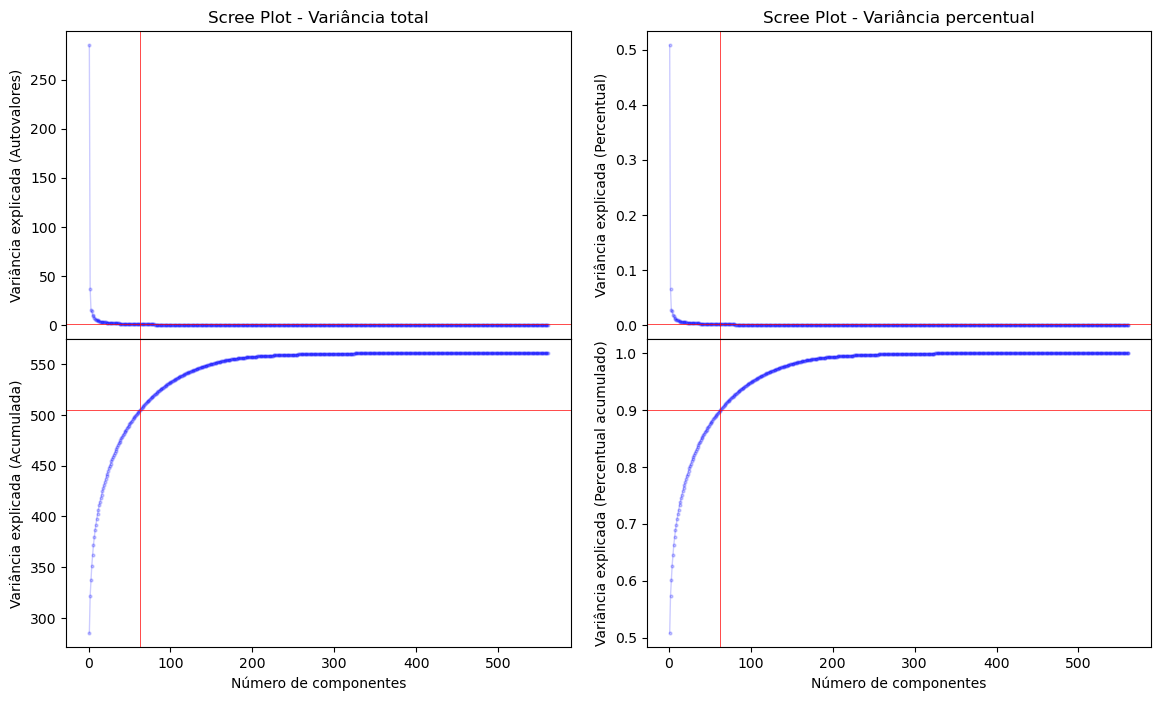

Para explicar 90% da variância com a padronização das variáveis, são necessárias 63 componentes.


In [49]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(14, 8))
plt.subplots_adjust(hspace=0, wspace=.15)

varexplicada = .90  # Define a variância explicada desejada
ncomp_criterio_pad = (princomp_pad.explained_variance_ratio_.cumsum() < varexplicada).sum() + 1

num_componentes_pad = np.arange(princomp_pad.n_components_) + 1
ax[0, 0].plot(num_componentes_pad, princomp_pad.explained_variance_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0 ,0].set_title('Scree Plot - Variância total')
ax[0, 0].set_xlabel('Número de componentes')
ax[0, 0].set_ylabel('Variância explicada (Autovalores)')

ax[1, 0].plot(num_componentes_pad, princomp_pad.explained_variance_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 0].set_xlabel('Número de componentes')
ax[1, 0].set_ylabel('Variância explicada (Acumulada)')

ax[0, 1].plot(num_componentes_pad, princomp_pad.explained_variance_ratio_, 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[0, 1].set_title('Scree Plot - Variância percentual')
ax[0, 1].set_xlabel('Número de componentes')
ax[0, 1].set_ylabel('Variância explicada (Percentual)')

ax[1, 1].plot(num_componentes_pad, princomp_pad.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue', markersize=2, alpha=.2)
ax[1, 1].set_xlabel('Número de componentes')
ax[1, 1].set_ylabel('Variância explicada (Percentual acumulado)')

ax[0, 0].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)
ax[1, 1].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)
ax[1, 0].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)
ax[0, 1].axvline(x=ncomp_criterio_pad, color='r', linestyle='-', linewidth=.5)

ax[0, 0].axhline(y=princomp_pad.explained_variance_[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)
ax[1, 0].axhline(y=princomp_pad.explained_variance_.cumsum()[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)
ax[0, 1].axhline(y=princomp_pad.explained_variance_ratio_[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)
ax[1, 1].axhline(y=princomp_pad.explained_variance_ratio_.cumsum()[ncomp_criterio_pad-1], color='r', linestyle='-', linewidth=.5)

plt.show()

print(f'Para explicar 90% da variância com a padronização das variáveis, são necessárias {ncomp_criterio_pad} componentes.')

A partir do método PCA é possível observar um aumento na quantidade de variância explicada pelos componentes. Em contrapartida, a base de dados não padronizada apresenta melhores resultados no tempo de processamento, requerendo apenas 34 componentes, resultado em uma modelagem mais ágil que a padronizada.

## Árvore com PCA

Faça duas uma árvore de decisão com 10 componentes principais - uma com base em dados padronizados e outra sem padronizar. Utilize o ```ccp_alpha=0.001```.

Compare a acurácia na base de treino e teste.

In [53]:
%%time
#SEM padronização

prcomp = PCA(n_components=10).fit(X_train)

pc_treino = prcomp.transform(X_train)
pc_teste  = prcomp.transform(X_test)

clf = DecisionTreeClassifier(ccp_alpha=0.001)
clf.fit(pc_treino, y_train)

print(f'Acurácia na base de treinamento sem padronização: {clf.score(pc_treino, y_train)}')
print(f'Acurácia na base de teste sem padronização: {clf.score(pc_teste, y_test)}\n')

Acurácia na base de treinamento sem padronização: 0.8924102285092492
Acurácia na base de teste sem padronização: 0.823210044112657

CPU times: total: 906 ms
Wall time: 238 ms


In [52]:
%%time
# COM padronização

prcomp_pad = PCA(n_components=10).fit(X_train_pad)

pc_treino_pad = prcomp_pad.transform(X_train_pad)
pc_teste_pad  = prcomp_pad.transform(X_test_pad)

clf_pad = DecisionTreeClassifier(ccp_alpha=0.001)
clf_pad.fit(pc_treino_pad, y_train)

print(f'Acurácia na base de treinamento com padronização: {clf_pad.score(pc_treino_pad, y_train)}')
print(f'Acurácia na base de teste com padronização: {clf_pad.score(pc_teste_pad, y_test)}\n')

Acurácia na base de treinamento com padronização: 0.8586779107725789
Acurácia na base de teste com padronização: 0.7733288089582626

CPU times: total: 797 ms
Wall time: 239 ms


A partir desta análise pode-se observar que a acurácia de treino e teste sem padronização são maiores que com padronização. 